# 1: IMPORT LIBRARIES AND DATASETS

In [3]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Import the necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers

In [5]:
# load facial key points data
training = pd.read_csv('/content/drive/My Drive/Proj/Untitled folder/data.csv')

In [6]:
training.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [7]:
# Obtain relavant information about the dataframe
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [8]:
# Check if null values exist in the dataframe
training.isnull().sum().sum()

0

In [9]:
# Since values for the image are given as space separated string, separate the values using ' ' as separator.
# Then convert this into numpy array using np.fromstring and convert the obtained 1D array into 2D array of shape (96, 96)
training['Image'] = training['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep = ' ').reshape(96, 96))

In [10]:
# Obtain the Shape of the image
training['Image'][0].shape

(96, 96)

In [11]:
training.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,66.221549,36.842274,29.640269,37.063815,59.272128,37.856014,73.412473,37.640110,36.603107,37.920852,22.361617,38.034571,56.147991,29.222304,79.617523,29.656570,39.272084,29.413747,15.761707,30.452947,47.952141,57.253926,63.419076,75.887660,32.967365,76.134065,48.081325,72.681125,48.149654,82.630412
std,2.087683,2.294027,2.051575,2.234334,2.005631,2.034500,2.701639,2.684162,1.822784,2.009505,2.768804,2.654903,2.819914,2.867131,3.312647,3.627187,2.609648,2.842219,3.337901,3.644342,3.276053,4.528635,3.650131,4.438565,3.595103,4.259514,2.723274,5.108675,3.032389,4.813557
min,47.835757,23.832996,18.922611,24.773072,41.779381,27.190098,52.947144,26.250023,24.112624,26.250023,11.054589,26.521633,35.581733,15.859361,55.549929,10.522325,25.060327,16.476000,3.826243,13.224453,24.472590,41.558400,43.869480,57.023258,9.778137,56.690208,32.260312,56.719043,33.047605,57.232296
25%,65.046300,35.468842,28.472224,35.818377,58.113054,36.607950,71.741978,36.102409,35.495730,36.766783,20.631964,36.569765,54.562757,27.590944,77.732395,27.658656,37.555192,27.798773,13.540535,28.268263,46.495330,54.466000,61.341291,72.874263,30.879288,73.280038,46.580004,69.271669,46.492000,79.417480
50%,66.129065,36.913319,29.655440,37.048085,59.327154,37.845220,73.240045,37.624207,36.620735,37.920336,22.529600,37.876900,56.239984,29.468466,79.797607,29.753523,39.247681,29.528098,15.760876,30.333323,47.900511,57.638582,63.199057,75.682465,33.034022,75.941985,47.939031,72.395978,47.980854,82.388899
75%,67.332093,38.286438,30.858673,38.333884,60.521492,39.195431,74.978684,39.308331,37.665280,39.143921,24.202338,39.401034,57.926361,31.079433,81.559651,31.763791,40.824154,31.134740,17.871569,32.661300,49.260657,60.303524,65.302398,78.774969,35.063575,78.884031,49.290000,75.840286,49.551936,85.697976
max,78.013082,46.132421,42.495172,45.980981,69.023030,47.190316,87.032252,49.653825,47.293746,44.887301,40.050971,50.002113,67.752000,40.293408,94.269957,48.823425,51.300571,39.445859,39.676082,44.857962,65.279654,75.992731,84.767123,94.673637,50.973348,93.443176,61.804506,93.916338,62.438095,95.808983


# 2: PERFORM Data VISUALIZATION

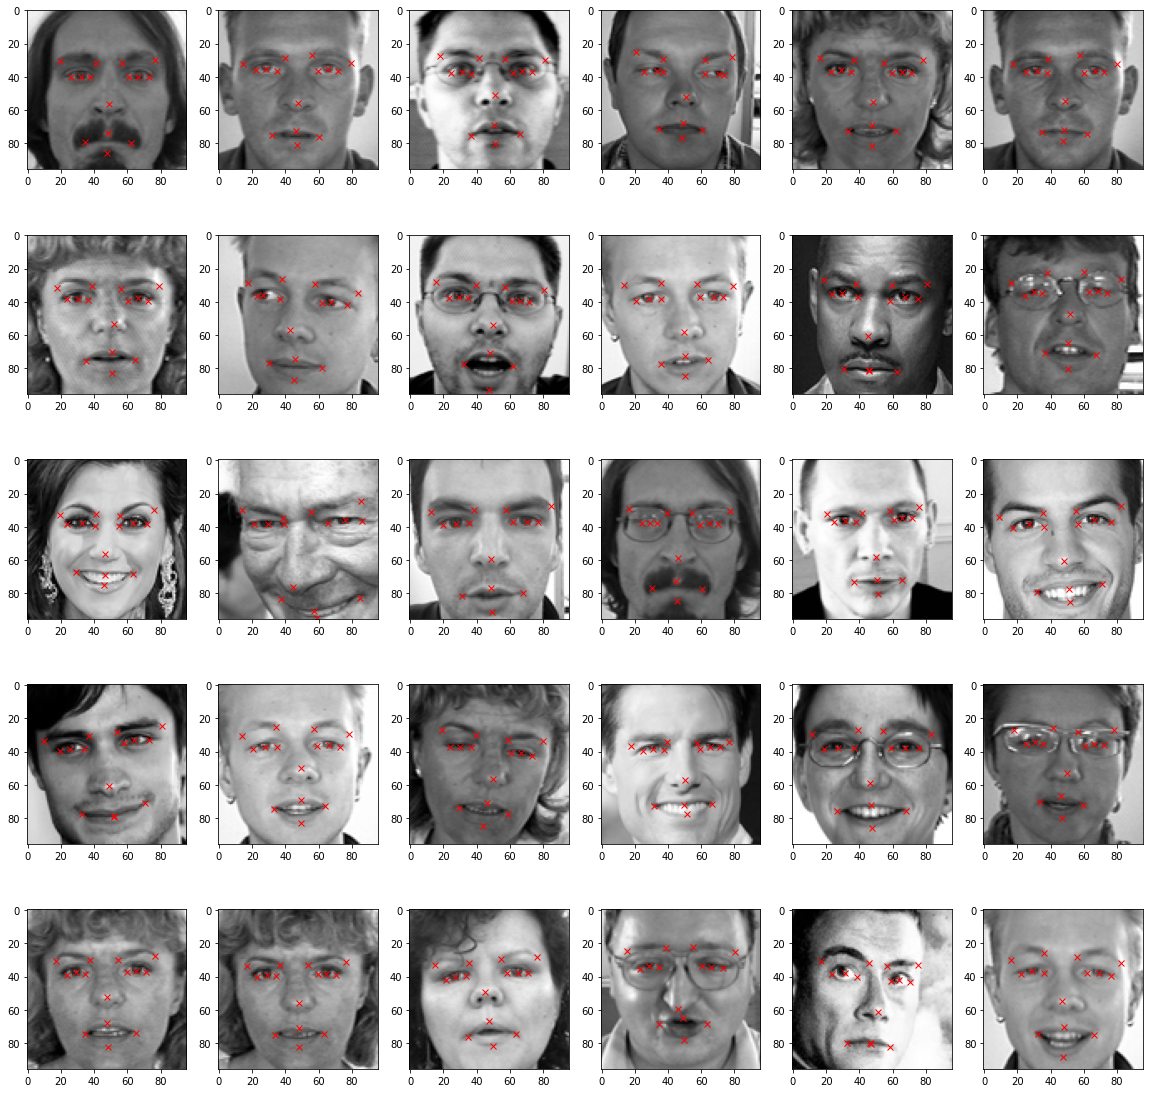

In [12]:
import random # for visualizing random images

fig = plt.figure(figsize=(20, 20))
for i in range(30):
    k = random.randint(1, len(training))
    ax = fig.add_subplot(5, 6, i + 1)    
    image = plt.imshow(training['Image'][k],cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(training.loc[k][j-1], training.loc[k][j], 'rx')
    

# 3: IMAGE DATA AUGMENTATION

In [13]:
# Create a new copy of the dataframe
import copy
training_copy = copy.copy(training)

In [14]:
# Obtain the columns in the dataframe
columns = training_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

## Horizontal Flip - flip the images along y axis

In [15]:
training_copy['Image'] = training_copy['Image'].apply(lambda x: np.flip(x, axis = 1))

# since we are flipping horizontally, y coordinate values would be the same
# Only x coordiante values would change, all we have to do is to subtract our initial x-coordinate values from width of the image(96)
for i in range(len(columns)):
  if i%2 == 0:
    training_copy[columns[i]] = training_copy[columns[i]].apply(lambda x: 96. - float(x) )

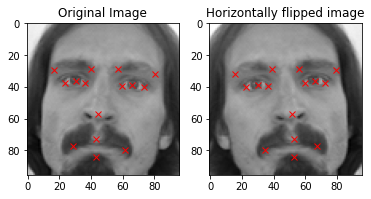

In [16]:
# Show the Original image
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(training['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(training.loc[0][j-1], training.loc[0][j], 'rx')

# Show the Horizontally flipped image
plt.subplot(1,2,2)
plt.title('Horizontally flipped image')
plt.imshow(training_copy['Image'][0],cmap='gray')
for j in range(1, 31, 2):
        plt.plot(training_copy.loc[0][j-1], training_copy.loc[0][j], 'rx')

In [17]:
# Concatenate the original dataframe with the augmented dataframe
augmented_df = np.concatenate((training, training_copy))
augmented_df.shape

(4280, 31)

## Randomingly increasing the brightness of the images

In [18]:
# We multiply pixel values by random values between 1.5 and 2 to increase the brightness of the image
# we clip the value between 0 and 255

import random

training_copy = copy.copy(training)
training_copy['Image'] = training_copy['Image'].apply(lambda x:np.clip(random.uniform(1.5, 2)* x, 0.0, 255.0))
augmented_df = np.concatenate((augmented_df, training_copy))
augmented_df.shape

(6420, 31)

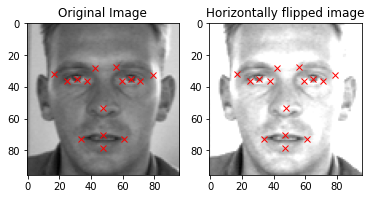

In [19]:
# Show the Original image
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(training['Image'][2], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(training.loc[2][j-1], training.loc[2][j], 'rx')

# Show the Bightened image
plt.subplot(1,2,2)
plt.title('Horizontally flipped image')
plt.imshow(training_copy['Image'][2],cmap='gray')
for j in range(1, 31, 2):
        plt.plot(training_copy.loc[2][j-1], training_copy.loc[2][j], 'rx')

# 4: PERFORM DATA NORMALIZATION AND TRAINING TEST SPLIT

In [20]:
# Obtain the value of images which is present in the 31st column (since index start from 0, we refer to 31st column by 30)
img = augmented_df[:,30]

# Normalize the images
img = img/255.

# Create an empty array of shape (x, 96, 96, 1) to feed the model
X = np.empty((len(img), 96, 96, 1))

# Iterate through the img list and add image values to the empty array after expanding it's dimension from (96, 96) to (96, 96, 1)
for i in range(len(img)):
  X[i,] = np.expand_dims(img[i], axis = 2)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(6420, 96, 96, 1)

In [21]:
# Obtain the value of x & y coordinates which are to used as target.
y = augmented_df[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

(6420, 30)

## Split the data into train and test data

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print('Training size is {} and test size is {}'.format(len(X_train), len(X_test)))

Training size is 5136 and test size is 1284


# 5: BUILD DEEP RESIDUAL NEURAL NETWORK KEY FACIAL POINTS DETECTION MODEL 

In [23]:
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1), name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [24]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128,128,512], stage= 3)

# 4 - stage
X = res_block(X, filter= [256,256,1024], stage= 4)

# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model = Model( inputs= X_input, outputs = X)

adam = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model.compile(loss = "mean_squared_error", 
              optimizer = adam , 
              metrics = [tf.keras.metrics.RootMeanSquaredError()]
             )
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
_______________________________________________________________________________________

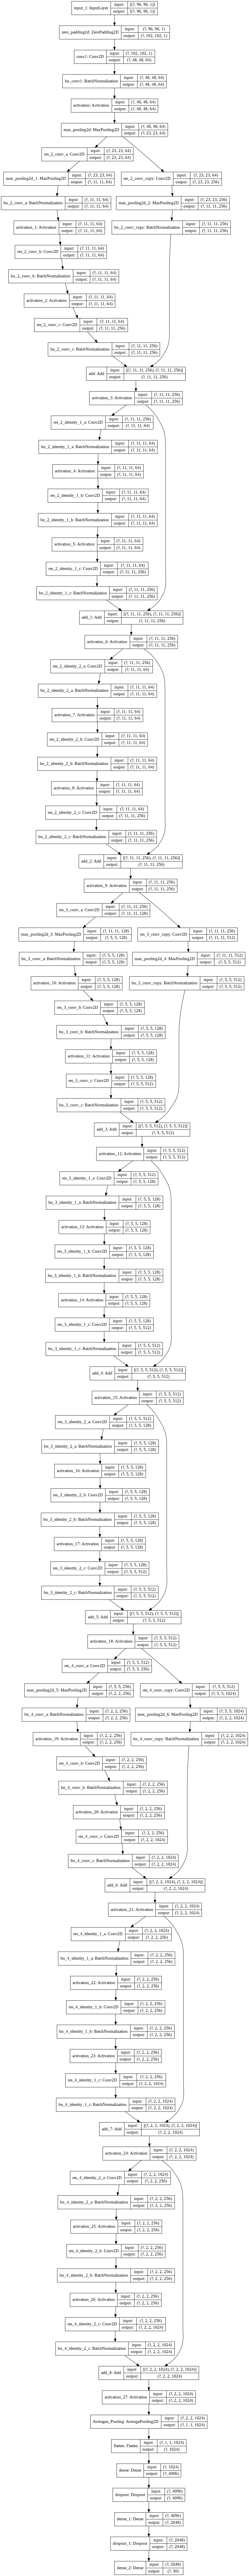

In [25]:
plot_model(model, to_file='/content/drive/My Drive/Proj/Untitled folder/Model/landmark.png', show_shapes=True)

# 6: TRAIN KEY FACIAL POINTS DETECTION DEEP LEARNING MODEL

In [26]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Proj/Untitled folder/Model/FacialKeyPoints_weights.hdf5",
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001
                             )
callbacks = [checkpointer, reduce_lr]

In [27]:
h = model.fit(X_train, y_train, 
              batch_size=32, 
              epochs=100, 
              validation_split=0.15, 
              callbacks=callbacks
             )

Epoch 1/100
137/137 [==============================] - ETA: 0s - loss: 373.0460 - root_mean_squared_error: 19.3144
Epoch 00001: val_loss improved from inf to 930.30688, saving model to /content/drive/My Drive/Proj/Untitled folder/Model/FacialKeyPoints_weights.hdf5
137/137 [==============================] - 7s 55ms/step - loss: 373.0460 - root_mean_squared_error: 19.3144 - val_loss: 930.3069 - val_root_mean_squared_error: 30.5009
Epoch 2/100
137/137 [==============================] - ETA: 0s - loss: 136.2433 - root_mean_squared_error: 11.6723
Epoch 00002: val_loss improved from 930.30688 to 282.64005, saving model to /content/drive/My Drive/Proj/Untitled folder/Model/FacialKeyPoints_weights.hdf5
137/137 [==============================] - 6s 47ms/step - loss: 136.2433 - root_mean_squared_error: 11.6723 - val_loss: 282.6400 - val_root_mean_squared_error: 16.8119
Epoch 3/100
137/137 [==============================] - ETA: 0s - loss: 85.0412 - root_mean_squared_error: 9.2218
Epoch 00003: va

In [29]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("drive/My Drive/Proj/Untitled folder/Model/FacialKeyPoints_model.json","w") as json_file:
  json_file.write(model_json)


# 7: MODEL PERFOMANCE & EVAUATION

In [30]:
# Evaluate the model
result = model.evaluate(X_test, y_test)

41/41 [==============================] - 1s 15ms/step - loss: 60.5931 - root_mean_squared_error: 7.7842


In [31]:
# Get the model keys 
h.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error', 'lr'])

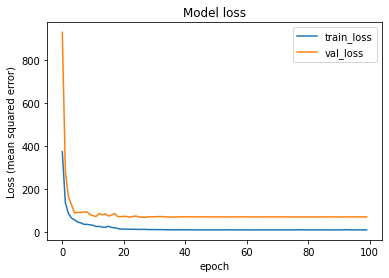

In [32]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss (mean squared error)')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()


# 8: VISUALIZING RESUTS 

In [33]:
pred = model.predict(X_test)

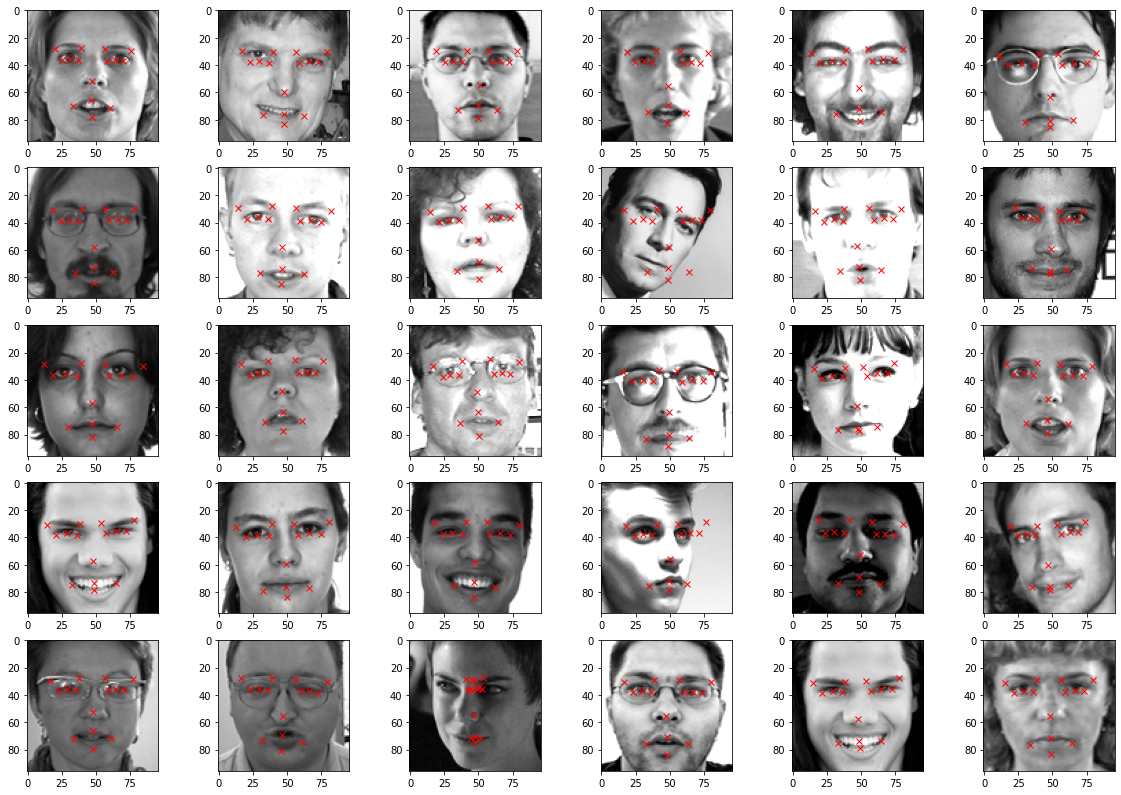

In [34]:
fig = plt.figure(figsize=(20,14))

for i in range(30):
  k = random.randint(1, len(X_test))    # chosing a random prediction 
  fig.add_subplot(5,6,i+1)
  plt.imshow(X_test[k].reshape(96,96), cmap='gray')
  for j in range(1,31,2):
    plt.plot(pred[k][j-1], pred[k][j], 'rx')

most of predictions seems correct but some are mistaken